![header image](https://storage.googleapis.com/kaggle-competitions/kaggle/7391/logos/header.png)
# Corporación Favorita Grocery Sales in Ecuador
The dataset contains sales data of groceries from a total of 46 stores in Ecuador, 18 of which are in the capital Quito. The data is collected from January 1st 2013 to late 2017.

---
## Explorative analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%ls

Exploration.ipynb      items.csv              test.csv
README.md              oil.csv                train.csv
food_prices.csv        sample_submission.csv  transactions.csv
holidays_events.csv    stores.csv             weather.csv


First, load the auxilary data and examine the column names and data formats. It is not best practice to fill large chunks of missing data by interpolation, but the actual analysis is not conducted with parts of the data where long interpolation is needed (weather data, spring 2014).

In [54]:
date_index = pd.date_range(start = '2013-01-01', end = '2017-08-14')
items = pd.read_csv('items.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
weather = pd.read_csv('weather.csv', parse_dates=['DATE'])
food_prices = pd.read_csv('food_prices.csv', header=0).loc[1:,:]

items.info()

oil = oil.set_index('date').sort_index()
oil = oil.reindex(date_index)
oil.loc['2013-01-01',:]=oil.loc['2013-01-02',:]
oil.loc[:,'oil_price'] = oil.loc[:,'dcoilwtico'].fillna(method='ffill')
oil = oil.drop('dcoilwtico', axis=1)
oil.info()

weather = weather.loc[:,['DATE', 'PRCP', 'TAVG', 'TMAX', 'TMIN']].rename(
    columns={
        'DATE': 'date',
        'PRCP': 'precipitation',
        'TAVG': 'tavg',
        'TMAX': 'tmax',
        'TMIN': 'tmin'
    })
weather = weather.set_index('date').sort_index()
weather = weather.reindex(date_index)
weather['precipitation'] = weather['precipitation'].fillna(0)
weather = weather.interpolate(method='time')
weather.info()

food_prices = food_prices.loc[food_prices['mktname']=='Quito',['date', 'cmname','sn', 'price']]
food_prices['date'] = pd.to_datetime(food_prices['date']) 
food_prices = food_prices.pivot(index='date', columns='sn', values = 'price').sort_index()
food_prices = food_prices.loc['2013-01-01':'2017-12-31',:].dropna(how='all', axis=1)
food_prices = food_prices.rename(columns={
    '2598_136_14_93': 'yellow maize',
    '2598_162_14_5': 'rice',
    '2598_51_14_5': 'white maize',
    '2598_58_14_22': 'wheat flour',
    '2598_599_14_93': 'wheat',
    '2598_83_14_5': 'potatoes'
}).astype(float)
food_prices = food_prices.reindex(date_index)
food_prices = food_prices.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')
food_prices.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1687 entries, 2013-01-01 to 2017-08-14
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   oil_price  1687 non-null   float64
dtypes: float64(1)
memory usage: 90.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1687 entries, 2013-01-01 to 2017-08-14
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1687 non-null   float64
 1   tavg           1687 non-null   float64
 

Text(0.5, 1.0, 'precipitation')

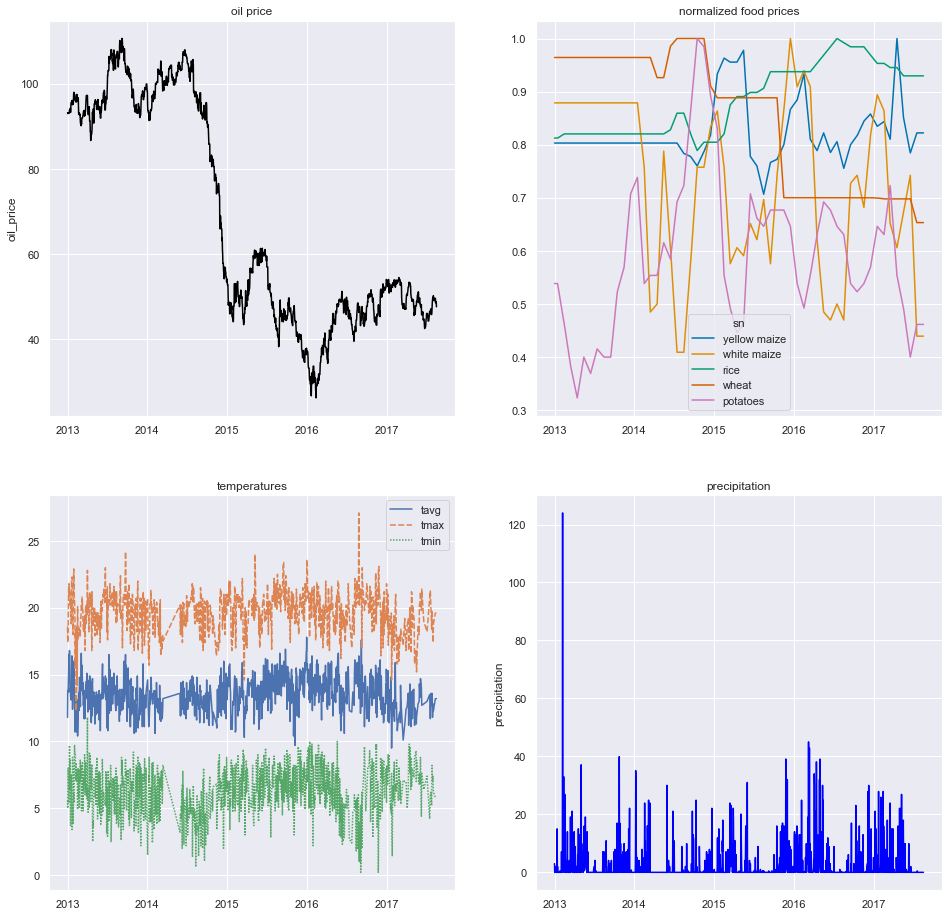

In [56]:
sns.set_theme()
fig, ax = plt.subplots(2,2, figsize=(16,16))
sns.lineplot(y=oil['oil_price'], x=oil.index, ax=ax[0,0], color='black').set_title('oil price')
sns.lineplot(data=weather.loc[:,['tavg', 'tmax', 'tmin']], ax=ax[1,0]).set_title('temperatures')

sns.set_palette('colorblind')
food_prices_norm = food_prices.loc[:,['yellow maize', 'white maize', 'rice', 'wheat', 'potatoes']].apply(lambda x: x/x.max(), axis=0)
sns.lineplot(data = food_prices_norm, ax=ax[0,1], dashes=False ).set_title('normalized food prices')

sns.lineplot(y=weather['precipitation'], x=weather.index, ax=ax[1,1], color='blue').set_title('precipitation')

Aggregate the sales data to daily level without store level information.

In [64]:
# Variable for holding the resulting data frame
sales_df=pd.DataFrame()
# Variable for holding the incomplete data of the day that was cut in half due to the chunking process.
extra=pd.DataFrame()

# Process the data in chunks to ensure memory availability
with pd.read_csv('train.csv', chunksize=10**6, parse_dates=['date']) as reader:
    for chunk in reader:
        chunk = chunk.set_index('date')
        
        # Process the last day with the next chunk in case it has been broken in half by the chunking.
        last_day = chunk.index.max()
        chunk = extra.append(chunk)
        extra = chunk.loc[last_day,:]
        chunk = chunk.loc[chunk.index.difference(pd.Index([last_day])), :]

        # Include the store information and filter by stores that are in the capital (Quito)
        chunk = chunk.join(stores['city'], how='left', on='store_nbr')
        chunk = chunk.loc[chunk['city']=='Quito']
        chunk = chunk.loc[:,['item_nbr', 'unit_sales', 'onpromotion']]
        chunk = chunk.groupby(by='date').apply(
            lambda df: df.merge(
                items, how='right', on='item_nbr'
            ).fillna(0)
        )
        chunk = chunk.reset_index().drop('level_1', axis=1)
        chunk = chunk.groupby(by=['family', 'date']).agg(
                unit_sales = pd.NamedAgg(column='unit_sales', aggfunc='sum'), # Number of units of items sold
                onpromotion = pd.NamedAgg(column='onpromotion', aggfunc='sum'), # Number of items on promotion
                items = pd.NamedAgg(column='item_nbr', aggfunc='nunique') # Number of items types sold
        )
        
        sales_df = sales_df.append(chunk).sort_index()
        #print(chunk.index[-1][1])
        
sales_df.loc[:,'onpromotion'] = sales_df.loc[:,'onpromotion'].fillna(0)
sales_df = sales_df.astype(float)
sales_df.head()

/Users/elias/opt/anaconda3/envs/kandi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


unit_sales  onpromotion  items
family     date                                      
AUTOMOTIVE 2013-01-02       123.0          0.0   20.0
           2013-01-03        82.0          0.0   20.0
           2013-01-04        71.0          0.0   20.0
           2013-01-05       184.0          0.0   20.0
           2013-01-06       198.0          0.0   20.0

Plot the sales data with promotion values to examine general trends.

<ipython-input-8-d6b0d8190838>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2,1)


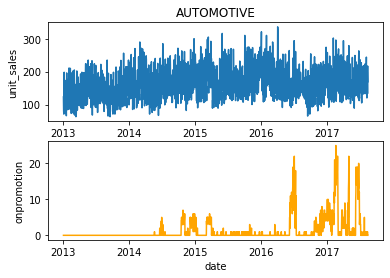

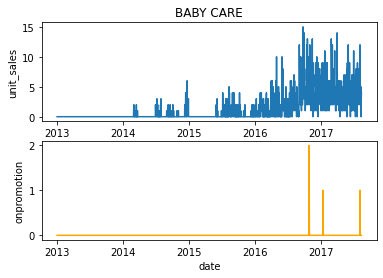

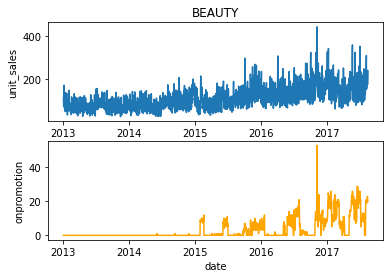

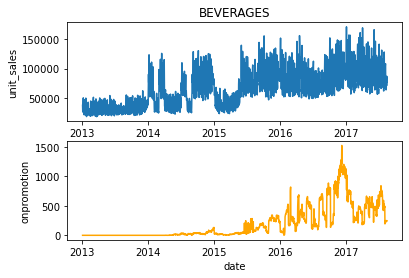

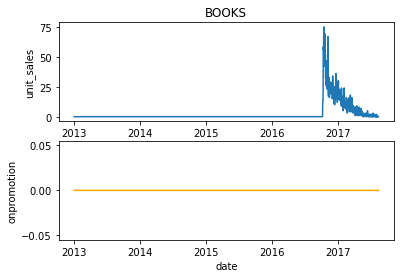

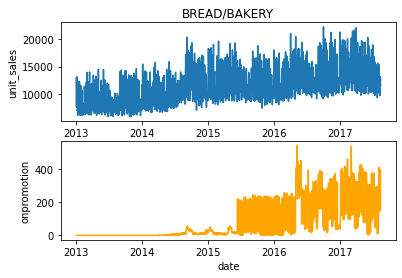

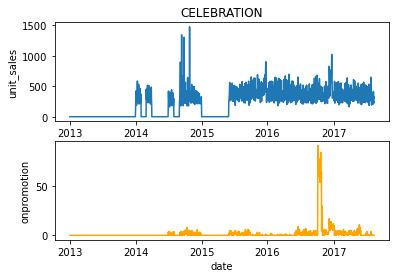

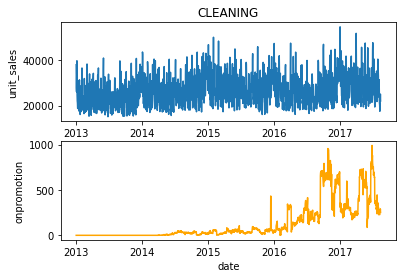

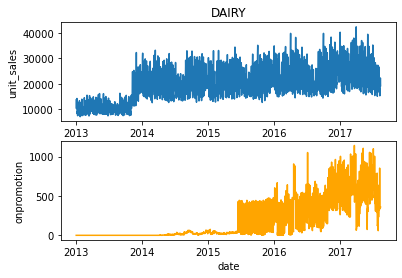

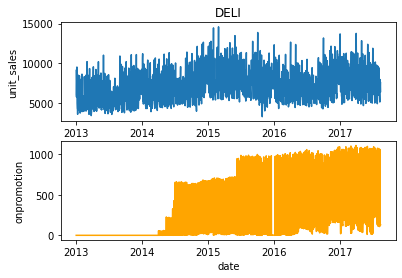

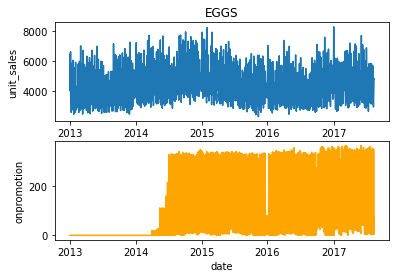

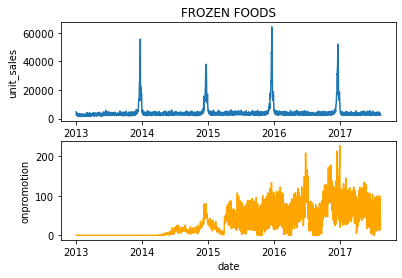

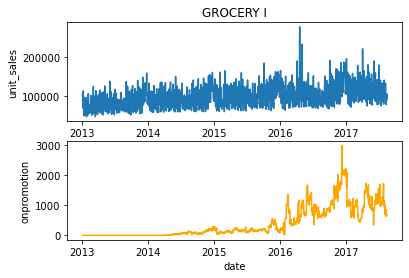

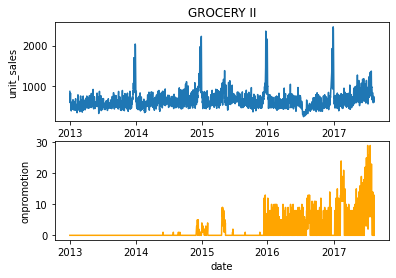

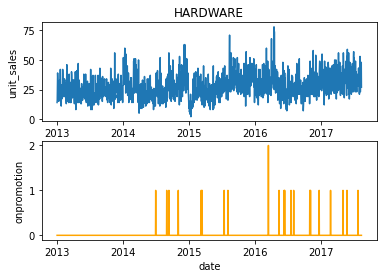

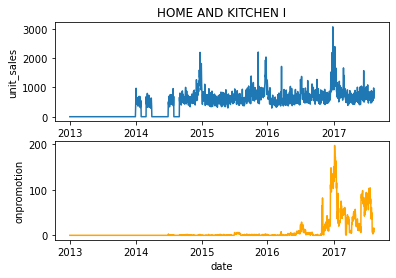

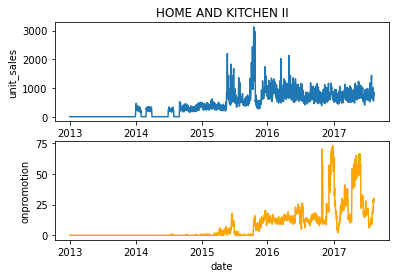

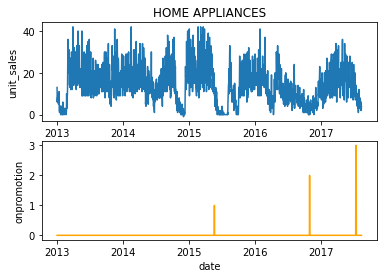

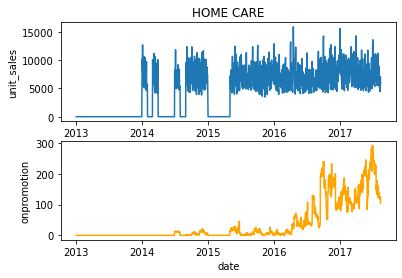

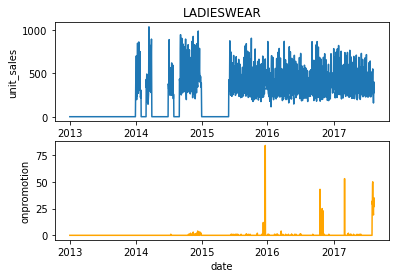

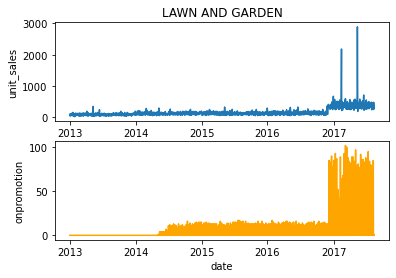

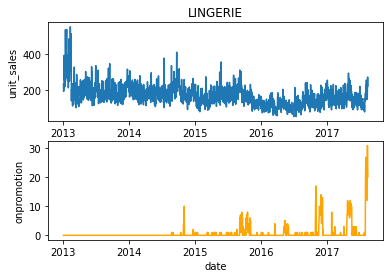

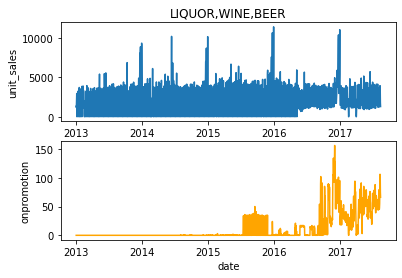

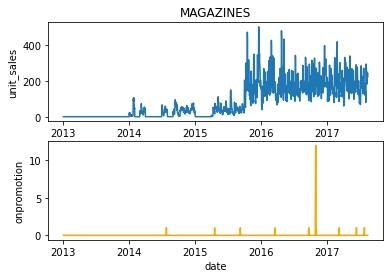

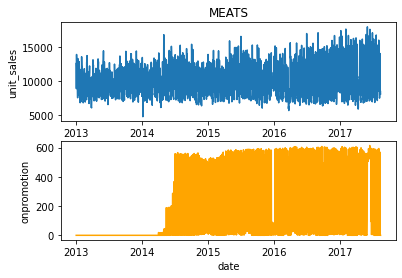

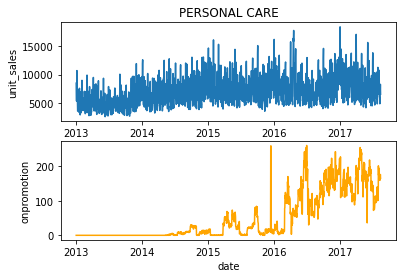

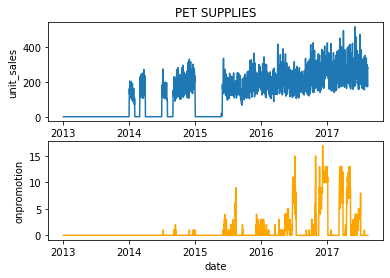

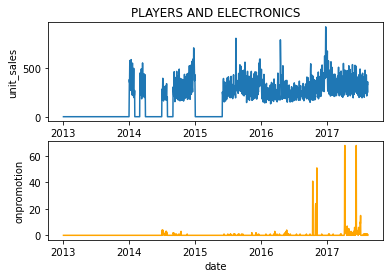

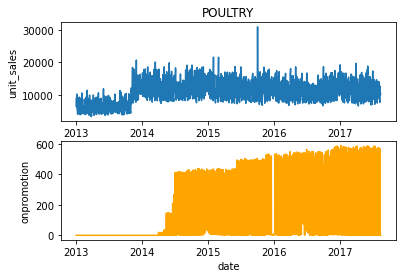

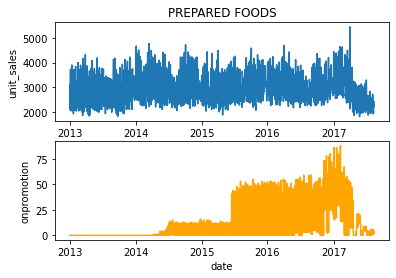

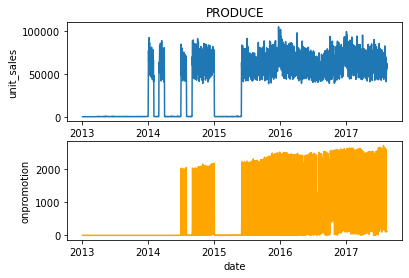

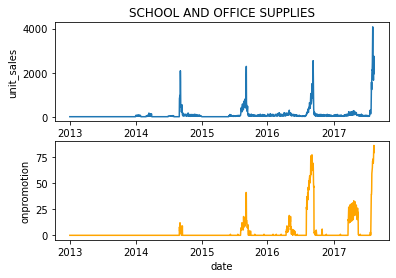

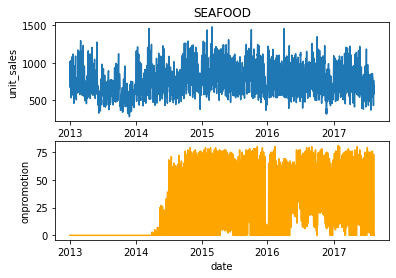

In [8]:
plt.close()
categories = sales_df.index.get_level_values('family').drop_duplicates()
for category in categories:
    data = sales_df.loc[category].astype(float).loc['2013-01-01':'2017-12-31',:]
    fig, ax = plt.subplots(2,1)
    sns.lineplot(y=data['unit_sales'], x=data.index, ax=ax[0]).set_title(category)
    sns.lineplot(y=data['onpromotion'], x=data.index, ax=ax[1], color='orange')

Merge the sales data with external variables to obtain the final dataset.

In [62]:
df = sales_df.copy()
df = df.join(oil, how='left', on='date')
df['oil_price'] = df['oil_price'].fillna(method='ffill')

df = df.join(weather, how='left', on='date')

df = df.join(food_prices, how='left', on='date')
categories = df.index.get_level_values(0).drop_duplicates()
for category in categories:
    interpolated=df.loc[
        category,
        ['yellow maize', 'rice', 'white maize', 'wheat flour', 'wheat', 'potatoes']
                       ].interpolate(method='time').fillna(method='bfill')
    df.loc[
        [category],
        ['yellow maize', 'rice', 'white maize', 'wheat flour', 'wheat', 'potatoes']
    ]=pd.concat([interpolated], keys=[category], names=['family'])
df

unit_sales  onpromotion  items  oil_price  \
family     date                                                    
AUTOMOTIVE 2013-01-02     123.000          0.0   20.0      93.14   
           2013-01-03      82.000          0.0   20.0      92.97   
           2013-01-04      71.000          0.0   20.0      93.12   
           2013-01-05     184.000          0.0   20.0      93.12   
           2013-01-06     198.000          0.0   20.0      93.12   
...                           ...          ...    ...        ...   
SEAFOOD    2017-08-10     433.118          0.0    8.0      48.54   
           2017-08-11     765.204         73.0    8.0      48.81   
           2017-08-12     613.881          6.0    8.0      48.81   
           2017-08-13     700.469          0.0    8.0      48.81   
           2017-08-14     588.476          0.0    8.0      47.59   

                       precipitation   tavg  tmax  tmin  yellow maize  rice  \
family     date                                                               
AUTOMOTIVE 2013-01-02            0.0  13.80  17.4  5.00         18.07  1.04   
           2013-01-03            0.0  13.80  18.6  7.20         18.07  1.04   
           2013-01-04            0.8  13.70  18.6  8.00         18.07  1.04   
           2013-01-05            0.0  14.45  19.9  7.35         18.07  1.04   
           2013-01-06            2.0  15.20  21.2  6.70         18.07  1.04   
...                              ...    ...   ...   ...           ...   ...   
SEAFOOD    2017-08-10            0.0  13.20  19.6  5.80         18.50  1.19   
           2017-08-11            0.0  13.20  19.6  5.80         18.50  1.19   
           2017-08-12            0.0  13.20  19.6  5.80         18.50  1.19   
           2017-08-13            0.0  13.20  19.6  5.80         18.50  1.19   
           2017-08-14            0.0  13.20  19.6  5.80         18.50  1.19   

                       white maize  wheat flour  wheat  potatoes  
family     date                                                   
AUTOMOTIVE 2013-01-02         0.58         38.0  17.27      0.35  
           2013-01-03         0.58         38.0  17.27      0.35  
           2013-01-04         0.58         38.0  17.27      0.35  
           2013-01-05         0.58         38.0  17.27      0.35  
           2013-01-06         0.58         38.0  17.27      0.35  
...                            ...          ...    ...       ...  
SEAFOOD    2017-08-10         0.29         33.4  11.70      0.30  
           2017-08-11         0.29         33.4  11.70      0.30  
           2017-08-12         0.29         33.4  11.70      0.30  
           2017-08-13         0.29         33.4  11.70      0.30  
           2017-08-14         0.29         33.4  11.70      0.30  

[55374 rows x 14 columns]

Save the dataset to avoid recalculating it each time.

Add external data to explain parts of seasonality and trend

In [63]:
df.to_csv('ecuador_dataset.csv')

Checking the relationship between the oil price and sales

In [212]:
from sklearn.linear_model import LinearRegression
total = df.loc[:,['unit_sales', 'onpromotion', 'items']].sum(level=1)
total['dcoilwtico'] = df['dcoilwtico'].max(level=1)
print(total)
reg = LinearRegression().fit(total['dcoilwtico'].fillna(method='ffill').values.reshape(-1,1), total['unit_sales'])
print(reg.coef_, reg.intercept_)
reg.score(total['dcoilwtico'].fillna(method='ffill').values.reshape(-1,1), total['unit_sales'])

            unit_sales  onpromotion   items  dcoilwtico
date                                                   
2013-01-02  265793.705          0.0  4100.0       93.14
2013-01-03  186344.714          0.0  4100.0       92.97
2013-01-04  187015.227          0.0  4100.0       93.12
2013-01-05  254984.499          0.0  4100.0       93.12
2013-01-06  291115.833          0.0  4100.0       93.12
...                ...          ...     ...         ...
2017-08-10  271132.404       2510.0  4100.0       48.54
2017-08-11  352846.886       5082.0  4100.0       48.81
2017-08-12  338428.838       2643.0  4100.0       48.81
2017-08-13  377727.754       2791.0  4100.0       48.81
2017-08-14  326433.518       2560.0  4100.0       47.59

[1678 rows x 4 columns]
[-2323.85494794] 464375.8234859657


0.2959713696461327